In [6]:
# ─── Configuración inicial ────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
from collections import Counter
import time
import os

# ─── Manipulación de datos ────────────────────────────────────────────────────
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# ─── Visualización ────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)

# ─── Preprocesamiento ─────────────────────────────────────────────────────────
from sklearn.preprocessing import (StandardScaler, KBinsDiscretizer, OrdinalEncoder, 
                                  LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer

# ─── Balanceo de datos ────────────────────────────────────────────────────────
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ─── Selección de características ─────────────────────────────────────────────
from sklearn.feature_selection import RFE, SelectFromModel

# ─── Modelado y evaluación ────────────────────────────────────────────────────
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                   StratifiedKFold, GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, 
                             StackingClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# ─── Métricas ─────────────────────────────────────────────────────────────────
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, f1_score, roc_auc_score,
                           RocCurveDisplay, PrecisionRecallDisplay,
                           precision_recall_curve)

# ─── Exportación ──────────────────────────────────────────────────────────────
from docx import Document

Características seleccionadas por RFE: ['monto', 'dias_pago_cat', 'anio_creacion']
LogisticRegression — CV accuracy: 0.85
LogisticRegression — CV f1: 0.80
LogisticRegression — CV roc_auc: 0.92

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3030
           1       0.81      0.80      0.80      1767

    accuracy                           0.86      4797
   macro avg       0.85      0.85      0.85      4797
weighted avg       0.86      0.86      0.86      4797



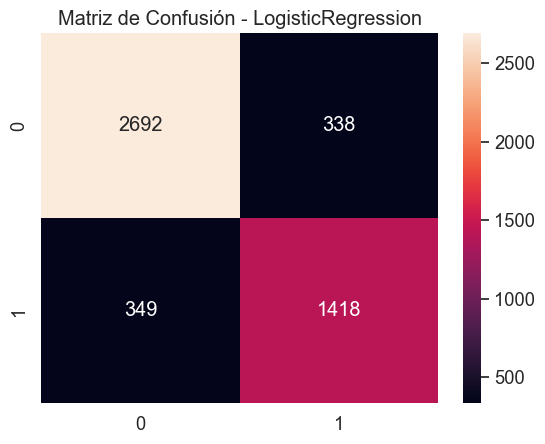

RandomForest — CV accuracy: 0.87
RandomForest — CV f1: 0.85
RandomForest — CV roc_auc: 0.95

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3030
           1       0.74      0.99      0.84      1767

    accuracy                           0.86      4797
   macro avg       0.86      0.89      0.86      4797
weighted avg       0.90      0.86      0.87      4797



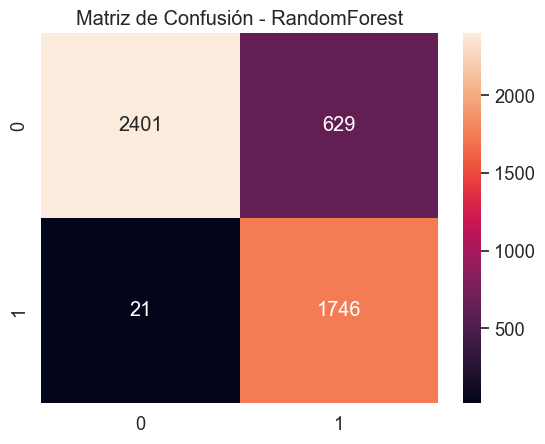

SVM — CV accuracy: 0.87
SVM — CV f1: 0.82
SVM — CV roc_auc: 0.94

=== SVM ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3030
           1       0.85      0.79      0.82      1767

    accuracy                           0.87      4797
   macro avg       0.87      0.86      0.86      4797
weighted avg       0.87      0.87      0.87      4797



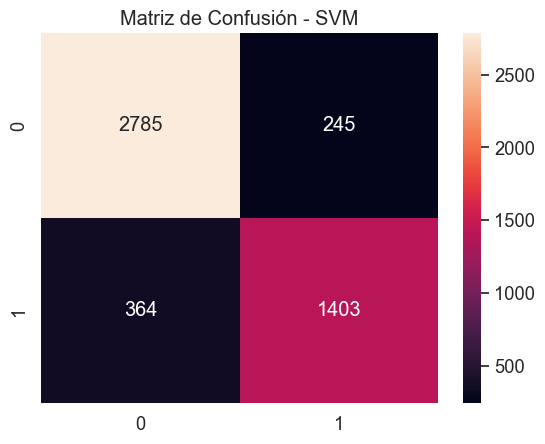

NaiveBayes — CV accuracy: 0.83
NaiveBayes — CV f1: 0.81
NaiveBayes — CV roc_auc: 0.94

=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3030
           1       0.68      1.00      0.81      1767

    accuracy                           0.82      4797
   macro avg       0.84      0.86      0.82      4797
weighted avg       0.88      0.82      0.83      4797



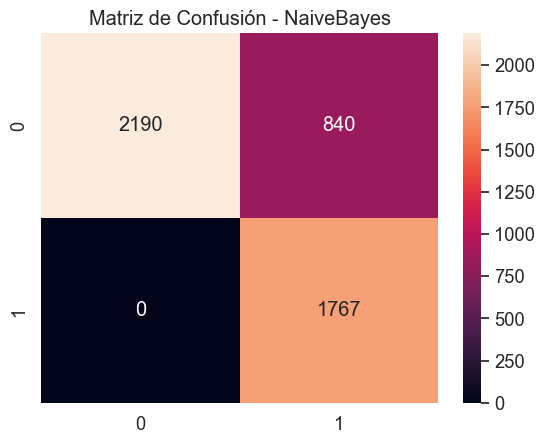

MLP — CV accuracy: 0.88
MLP — CV f1: 0.82
MLP — CV roc_auc: 0.95

=== MLP ===
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3030
           1       0.86      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.87      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



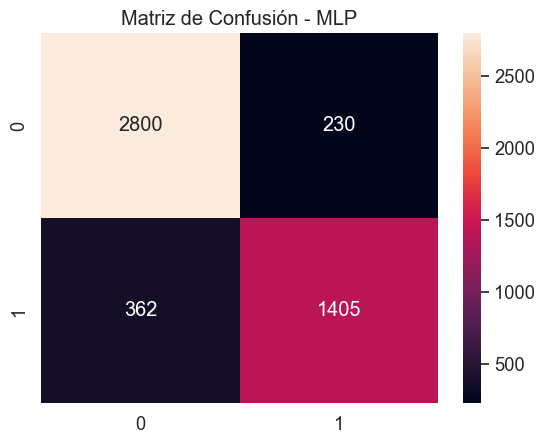

XGBoost — CV accuracy: 0.88
XGBoost — CV f1: 0.83
XGBoost — CV roc_auc: 0.95

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



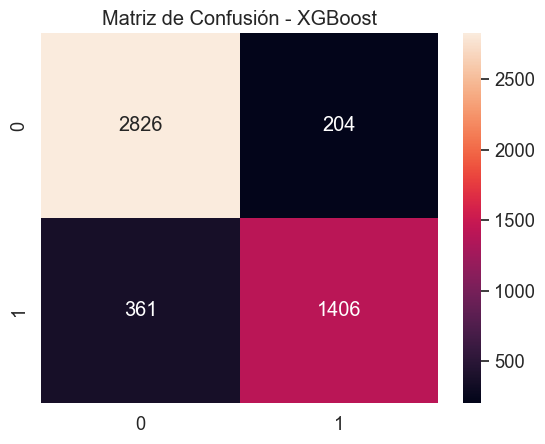

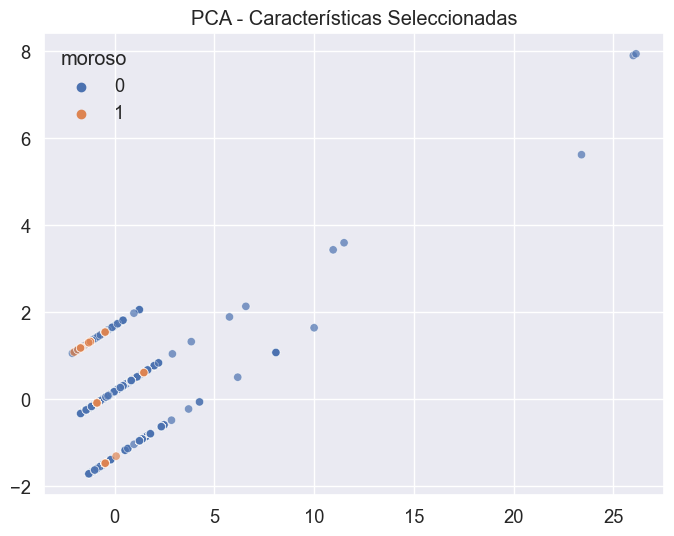

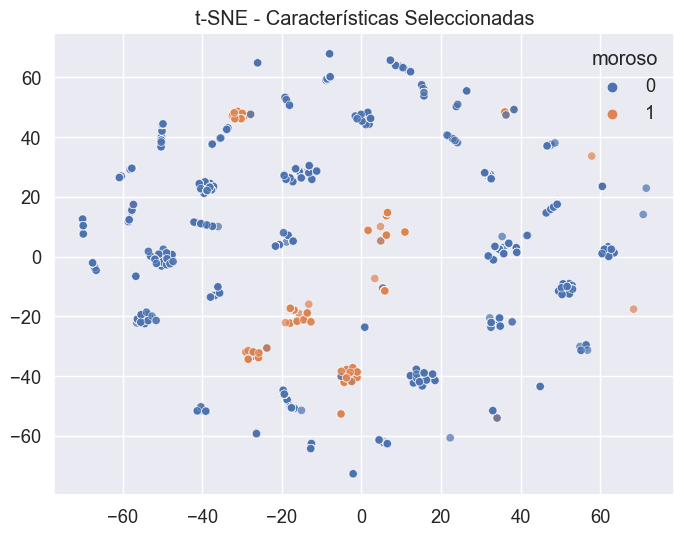

In [7]:
# Visualización
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Cargar datos
ruta = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx"
df = pd.read_excel(ruta)

# Preprocesamiento de fechas
date_cols = ['fecha_creacion', 'fecha_pago', 'hasta el mes']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Calcular días hasta pago
df['dias_pago'] = (df['fecha_pago'] - df['fecha_creacion']).dt.days

# Imputar valores faltantes en dias_pago (necesario antes de KBinsDiscretizer)
imputer_dias = SimpleImputer(strategy='mean')
df['dias_pago'] = imputer_dias.fit_transform(df[['dias_pago']])

# Transformar días de pago a categorías para evitar sobreajuste
disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
# fit y transform a la vez
df['dias_pago_cat'] = disc.fit_transform(df[['dias_pago']])


# Extracción de variables temporales
df['mes_creacion'] = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year

# Variable objetivo (sin fuga de información)
df['moroso'] = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)

# Codificación segura
categorical_columns = ['tipo']
le = LabelEncoder()
for col in categorical_columns:
    df[f'{col}_enc'] = le.fit_transform(df[col].astype(str).str.strip())

# Definir características relevantes (transformada días de pago)
features = ['monto', 'dias_pago_cat', 'mes_creacion', 'anio_creacion', 'tipo_enc']
X = df[features]
y = df['moroso']

# Imputación general y escalado
imp_general = SimpleImputer(strategy='mean')
X_imp      = imp_general.fit_transform(X)        # Ajusta e imputa una sola vez
scaler     = StandardScaler().fit(X_imp)         # Ajusta el escalador sobre X_imp
X_scaled   = scaler.transform(X_imp)             # Transforma con el mismo escalador



# Selección estricta de características usando RFE
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42), n_features_to_select=3)
selector.fit(X_scaled, y)
X_sel = selector.transform(X_scaled)
selected_features = [features[i] for i in range(len(features)) if selector.support_[i]]
print("Características seleccionadas por RFE:", selected_features)

# División de datos
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y, test_size=0.3, stratify=y, random_state=42)

# Modelos ajustados con mayor regularización
models = {
    'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=20, random_state=42),
    'SVM': SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(10,), alpha=0.5, max_iter=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluación con validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']
for name, model in models.items():
    for metric in scoring:
        scores = cross_val_score(model, X_sel, y, cv=skf, scoring=metric)
        print(f"{name} — CV {metric}: {scores.mean():.2f}")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, preds))
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# PCA y t-SNE para visualización clara
def plot_dimensionality_reduction(X, y, method='PCA'):
    if method == 'PCA':
        X_red = PCA(n_components=2, random_state=42).fit_transform(X)
        title = 'PCA'
    else:
        X_red = TSNE(n_components=2, random_state=42).fit_transform(X)
        title = 't-SNE'

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue=y, alpha=0.7)
    plt.title(f'{title} - Características Seleccionadas')
    plt.show()

plot_dimensionality_reduction(X_sel, y, 'PCA')
plot_dimensionality_reduction(X_sel, y, 't-SNE')


=== Fine-tuning LogisticRegression ===
Mejor combinación: {'C': 0.1}
F1: 0.81
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3030
           1       0.81      0.80      0.81      1767

    accuracy                           0.86      4797
   macro avg       0.85      0.85      0.85      4797
weighted avg       0.86      0.86      0.86      4797



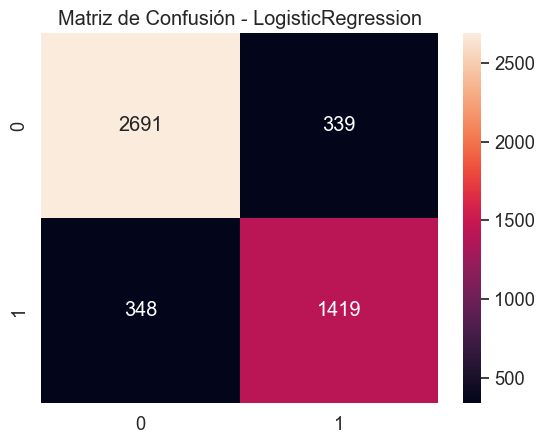


=== Fine-tuning RandomForest ===
Mejor combinación: {'n_estimators': 50, 'max_depth': 3}
F1: 0.84
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3030
           1       0.74      0.99      0.84      1767

    accuracy                           0.86      4797
   macro avg       0.86      0.89      0.86      4797
weighted avg       0.90      0.86      0.87      4797



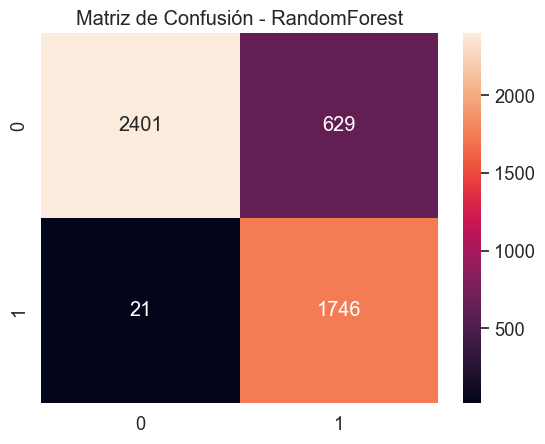


=== Fine-tuning SVM ===
Mejor combinación: {'C': 1, 'gamma': 'scale'}
F1: 0.83
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



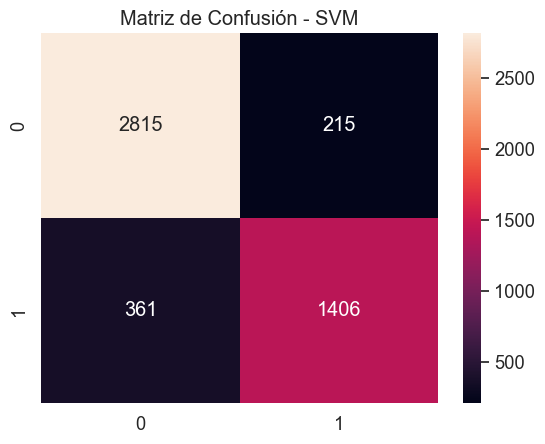


=== Fine-tuning MLP ===
Mejor combinación: {'hidden_layer_sizes': (20,), 'alpha': 0.01}
F1: 0.83
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3030
           1       0.87      0.79      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



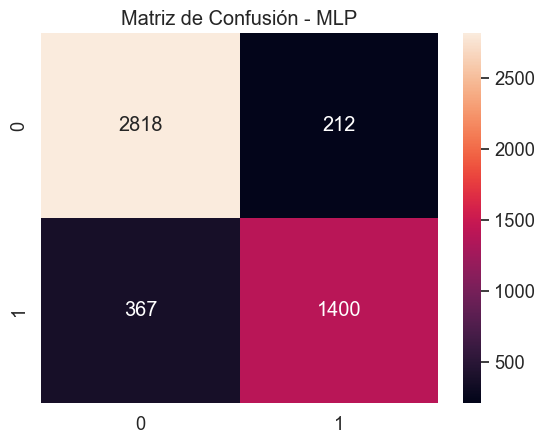


=== Fine-tuning XGBoost ===
Mejor combinación: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
F1: 0.83
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.87      0.87      4797
weighted avg       0.88      0.88      0.88      4797



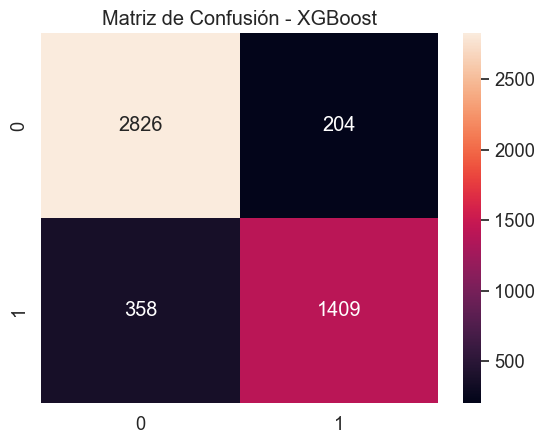


=== Fine-tuning NaiveBayes ===
Mejor combinación: {}
F1: 0.81
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3030
           1       0.68      1.00      0.81      1767

    accuracy                           0.82      4797
   macro avg       0.84      0.86      0.82      4797
weighted avg       0.88      0.82      0.83      4797



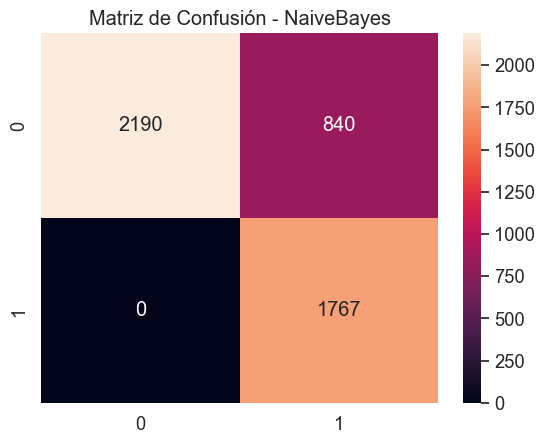

In [8]:
# Tuneo

# Hiperparámetros por modelo para fine-tuning
param_grid = {
    'LogisticRegression': [{'C': c} for c in [0.001, 0.01, 0.1, 1]],
    'RandomForest': [{'n_estimators': n, 'max_depth': d} for n in [50, 100] for d in [3, 5]],
    'SVM': [{'C': c, 'gamma': g} for c in [0.1, 1] for g in ['scale', 'auto']],
    'MLP': [{'hidden_layer_sizes': h, 'alpha': a} for h in [(10,), (20,)] for a in [0.01, 0.1]],
    'XGBoost': [{'n_estimators': n, 'max_depth': d, 'learning_rate': lr} for n in [50, 100] for d in [3, 5] for lr in [0.05, 0.1]],
    'NaiveBayes': [{}]  # No tiene hiperparámetros ajustables en su forma básica
}

# Evaluar combinaciones
for name in param_grid:
    print(f"\n=== Fine-tuning {name} ===")
    best_score = 0
    best_params = None
    for params in param_grid[name]:
        if name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, **params)
        elif name == 'RandomForest':
            model = RandomForestClassifier(min_samples_leaf=20, random_state=42, **params)
        elif name == 'SVM':
            model = SVC(probability=True, random_state=42, **params)
        elif name == 'MLP':
            model = MLPClassifier(max_iter=300, random_state=42, **params)
        elif name == 'XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)
        elif name == 'NaiveBayes':
            model = GaussianNB()  # sin params

        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)

        acc = accuracy_score(y_te, preds)
        f1 = f1_score(y_te, preds)
        proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else preds
        roc = roc_auc_score(y_te, proba)

        if f1 > best_score:
            best_score = f1
            best_params = params
            best_model = model

    print(f"Mejor combinación: {best_params}")
    print(f"F1: {best_score:.2f}")

    # Evaluación final del mejor modelo
    final_preds = best_model.predict(X_te)
    print(classification_report(y_te, final_preds))
    cm = confusion_matrix(y_te, final_preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


# Implementacion

In [9]:
# ─── CELDA 4: IMPLEMENTACIÓN DEL MODELO PARA NUEVOS CASOS ──────────────────────

# 1) Entrenar los modelos FINALES con mejores hiperparámetros sobre todo el conjunto
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=5,
    learning_rate=0.1, use_label_encoder=False,
    eval_metric='logloss', random_state=42
)
xgb_model.fit(X_sel, y)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(20,), alpha=0.01,
    max_iter=300, random_state=42
)
mlp_model.fit(X_sel, y)

# 2) Cargar nuevos datos
ruta_csv = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\pagos bse original.csv"
df_new = pd.read_csv(ruta_csv)

# Normalizar nombre de Id
if 'Id' not in df_new.columns and 'id' in df_new.columns:
    df_new.rename(columns={'id':'Id'}, inplace=True)

# 3) Misma pre-transformación de fechas UNIX → datetime
for c in ['fecha_creacion','fecha_pago']:
    df_new[c] = pd.to_datetime(df_new[c], unit='s', errors='coerce')

# 4) Calcular e imputar días de pago
df_new['dias_pago'] = (df_new['fecha_pago'] - df_new['fecha_creacion']).dt.days
df_new['dias_pago'] = imputer_dias.transform(df_new[['dias_pago']])

# 5) Discretizar días de pago
df_new['dias_pago_cat'] = disc.transform(df_new[['dias_pago']])

# 6) Extraer mes y año
df_new['mes_creacion']  = df_new['fecha_creacion'].dt.month
df_new['anio_creacion'] = df_new['fecha_creacion'].dt.year

# 7) Codificar 'tipo'
df_new['tipo_enc'] = le.transform(df_new['tipo'].astype(str).str.strip())

# 8) Construir matriz de características y escalar
Xn = imp_general.transform(df_new[features])
Xn_scaled = scaler.transform(Xn)
Xn_sel    = selector.transform(Xn_scaled)

# 9) Generar predicciones
df_new['pred_XGBoost'] = xgb_model.predict(Xn_sel)
df_new['prob_XGBoost'] = xgb_model.predict_proba(Xn_sel)[:,1]
df_new['pred_MLP']     = mlp_model.predict(Xn_sel)
df_new['prob_MLP']     = mlp_model.predict_proba(Xn_sel)[:,1]

# 10) Mostrar solo Id y predicciones
resultado = df_new[['Id','pred_XGBoost','prob_XGBoost','pred_MLP','prob_MLP']]
print(resultado.head(10))
#resultado.to_excel(r'C:\Users\AMUNGUIA\Desktop\salida_modelos.xlsx')


              Id  pred_XGBoost  prob_XGBoost  pred_MLP  prob_MLP
0  64c8f3c33be4d             0      0.000110         0  0.000001
1  64c8f3c33c478             0      0.000110         0  0.000001
2  64c8f3c33c5b7             0      0.000110         0  0.000001
3  64c8f3c33c68a             0      0.000110         0  0.000001
4  64c8f3c33c7a7             0      0.000110         0  0.000001
5  64c8f3c33c8be             0      0.000110         0  0.000001
6  64c8f3c33c984             0      0.000110         0  0.000001
7  64c8f3c33ca1e             0      0.000110         0  0.000001
8  64c8f3c33caee             0      0.000123         0  0.000001
9  64c8f3c33cb8d             0      0.000110         0  0.000001


# Pipeline

2025-05-30 12:43:23,292 INFO Datos cargados: 15989 filas x 18 columnas
2025-05-30 12:43:23,346 INFO GridSearch XGBoost...
2025-05-30 12:44:15,044 INFO   → Mejor XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}, F1=0.83
2025-05-30 12:44:15,048 INFO GridSearch MLP...
2025-05-30 12:44:58,969 INFO   → Mejor MLP params: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (20,)}, F1=0.83
2025-05-30 12:44:58,997 INFO === Report XGBoost ===


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.87      0.87      4797
weighted avg       0.88      0.88      0.88      4797



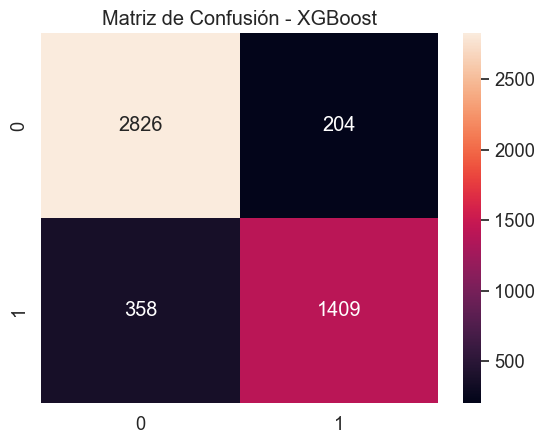

2025-05-30 12:44:59,263 INFO === Report MLP ===


              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3030
           1       0.87      0.79      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



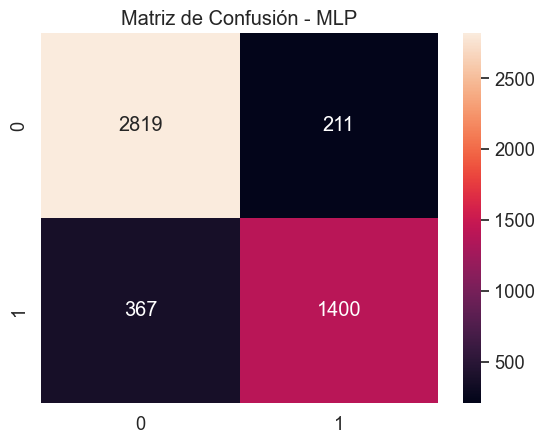

              Id  pred_XGB  prob_XGB  pred_XGB_bin  pred_MLP  prob_MLP  \
0  64c8f3c33be4d         0  0.000112             0         0  0.000044   
1  64c8f3c33c478         0  0.000112             0         0  0.000044   
2  64c8f3c33c5b7         0  0.000112             0         0  0.000044   
3  64c8f3c33c68a         0  0.000112             0         0  0.000044   
4  64c8f3c33c7a7         0  0.000112             0         0  0.000044   
5  64c8f3c33c8be         0  0.000112             0         0  0.000044   
6  64c8f3c33c984         0  0.000112             0         0  0.000044   
7  64c8f3c33ca1e         0  0.000112             0         0  0.000044   
8  64c8f3c33caee         0  0.000154             0         0  0.000055   
9  64c8f3c33cb8d         0  0.000112             0         0  0.000044   

   pred_MLP_bin  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9    

In [10]:
# ─── 1) Carga y QC inicial ──────────────────────────────────────────────────────
df = pd.read_excel(r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx")
logging.info(f"Datos cargados: {df.shape[0]} filas x {df.shape[1]} columnas")

# Pasamos fechas a datetime
for c in ['fecha_creacion','fecha_pago','hasta el mes']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Creamos variables
df['dias_pago']     = (df['fecha_pago'] - df['fecha_creacion']).dt.days
df['mes_creacion']  = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year
df['moroso']        = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)

# QC rápido
assert df[['monto','dias_pago','tipo']].notnull().any().all(), "¡Alguna columna clave viene toda a NaN!"

# ─── 2) Preprocesado + RFE dentro de pipelines ──────────────────────────────────

# 2.1 Features numéricos
num_feats = ['monto','mes_creacion','anio_creacion']
num_pipe = Pipeline([
    ('imp',   SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

# 2.2 Dias de pago
dias_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('bin', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
])

# 2.3 Categórico
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

preprocessor = ColumnTransformer([
    ('num',  num_pipe,  num_feats),
    ('dias', dias_pipe, ['dias_pago']),
    ('cat',  cat_pipe,  ['tipo']),
], remainder='drop')

# 2.4 RFE con RF
rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    n_features_to_select=3
)

# ─── 3) Definición de pipelines XGB y MLP + grids ───────────────────────────────

pipeline_xgb = Pipeline([
    ('pre', preprocessor),
    ('rfe', rfe),
    ('clf', XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )),
])

pipeline_mlp = Pipeline([
    ('pre', preprocessor),
    ('rfe', rfe),
    ('clf', MLPClassifier(max_iter=300, random_state=42))
])

param_grid = {
    'xgb': {
      'clf__n_estimators': [50,100],
      'clf__max_depth': [3,5],
      'clf__learning_rate': [0.05,0.1]
    },
    'mlp': {
      'clf__hidden_layer_sizes': [(10,),(20,)],
      'clf__alpha': [0.01,0.1]
    }
}

# ─── 4) Train/Test split ────────────────────────────────────────────────────────
X = df[num_feats + ['dias_pago','tipo']]
y = df['moroso']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ─── 5) Fine‐tuning con GridSearchCV ────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logging.info("GridSearch XGBoost...")
gs_xgb = GridSearchCV(pipeline_xgb, param_grid['xgb'], cv=cv, scoring='f1', n_jobs=-1)
gs_xgb.fit(X_tr, y_tr)
best_xgb = gs_xgb.best_estimator_
logging.info(f"  → Mejor XGB params: {gs_xgb.best_params_}, F1={gs_xgb.best_score_:.2f}")

logging.info("GridSearch MLP...")
gs_mlp = GridSearchCV(pipeline_mlp, param_grid['mlp'], cv=cv, scoring='f1', n_jobs=-1)
gs_mlp.fit(X_tr, y_tr)
best_mlp = gs_mlp.best_estimator_
logging.info(f"  → Mejor MLP params: {gs_mlp.best_params_}, F1={gs_mlp.best_score_:.2f}")

# ─── 6) Evaluación final ────────────────────────────────────────────────────────
for name, model in [('XGBoost', best_xgb), ('MLP', best_mlp)]:
    preds = model.predict(X_te)
    logging.info(f"=== Report {name} ===")
    print(classification_report(y_te, preds))
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# ─── 7) Despliegue sobre nuevos datos ────────────────────────────────────────────
# 7.1 Leer y QC
df_new = pd.read_csv(r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\pagos bse original.csv")
assert not df_new.empty, "No cargaron nuevos datos"

# 7.2 Misma transformación de fechas y creación de variables
for c in ['fecha_creacion','fecha_pago']:
    df_new[c] = pd.to_datetime(df_new[c], unit='s', errors='coerce')
df_new['dias_pago']     = (df_new['fecha_pago'] - df_new['fecha_creacion']).dt.days
df_new['mes_creacion']  = df_new['fecha_creacion'].dt.month
df_new['anio_creacion'] = df_new['fecha_creacion'].dt.year

# 7.3 Renombrar Id
if 'id' in df_new.columns and 'Id' not in df_new.columns:
    df_new = df_new.rename(columns={'id':'Id'})

# 7.4 Predicciones y probabilidades
df_new['pred_XGB']  = best_xgb.predict(df_new[X.columns])
df_new['prob_XGB']  = best_xgb.predict_proba(df_new[X.columns])[:,1]
df_new['pred_MLP']  = best_mlp.predict(df_new[X.columns])
df_new['prob_MLP']  = best_mlp.predict_proba(df_new[X.columns])[:,1]

# 7.5 Umbral ajustable
THRESHOLD = 0.5
df_new['pred_XGB_bin'] = (df_new['prob_XGB'] > THRESHOLD).astype(int)
df_new['pred_MLP_bin'] = (df_new['prob_MLP'] > THRESHOLD).astype(int)

resultado = df_new[['Id','pred_XGB','prob_XGB','pred_XGB_bin',
                    'pred_MLP','prob_MLP','pred_MLP_bin']]
print(resultado.head(10))
# Exportar a excel
# resultado.to_excel('salida_modelos.xlsx', index=False)
# Exportar a CSV
# csv_path = r"C:\Users\AMUNGUIA\Desktop\Resultados_Modelado.csv"
# df_resultados.to_csv(csv_path, index=False)
#print(f"Resultados exportados a CSV: {csv_path}")


# Ensambles


=== Voting ===
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.79      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



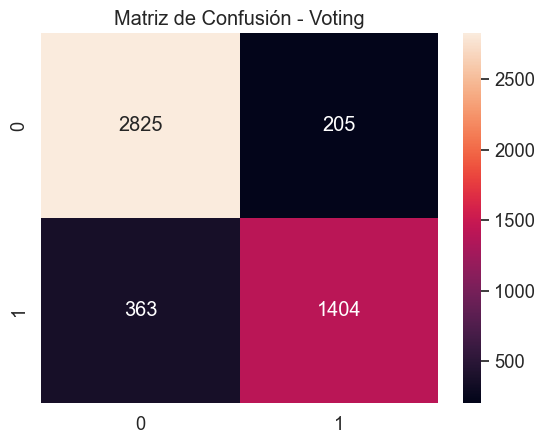


=== Stacking ===
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3030
           1       0.74      0.99      0.85      1767

    accuracy                           0.87      4797
   macro avg       0.87      0.90      0.87      4797
weighted avg       0.90      0.87      0.87      4797



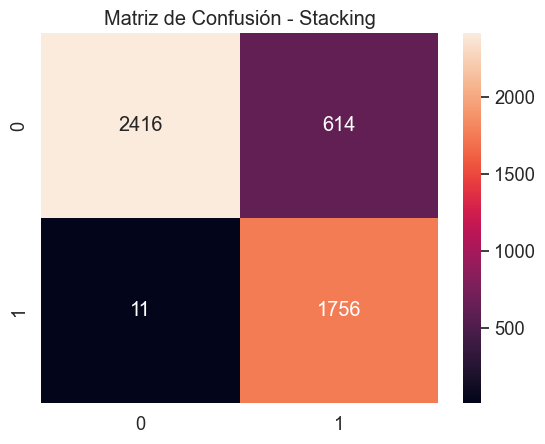


Comparativa de modelos:
     Modelo        F1  Accuracy   ROC_AUC     Tiempo  \
0  Stacking  0.848924  0.869710  0.954030  71.717085   
1   XGBoost  0.833728  0.882843  0.953589        NaN   
2    Voting  0.831754  0.881593  0.953288  10.192000   
3       MLP  0.828893  0.879508  0.951683        NaN   

                                          Modelo_obj  
0  StackingClassifier(cv=5,\n                   e...  
1  (ColumnTransformer(transformers=[('num',\n    ...  
2  VotingClassifier(estimators=[('rf',\n         ...  
3  (ColumnTransformer(transformers=[('num',\n    ...  

Modelo final seleccionado: Stacking


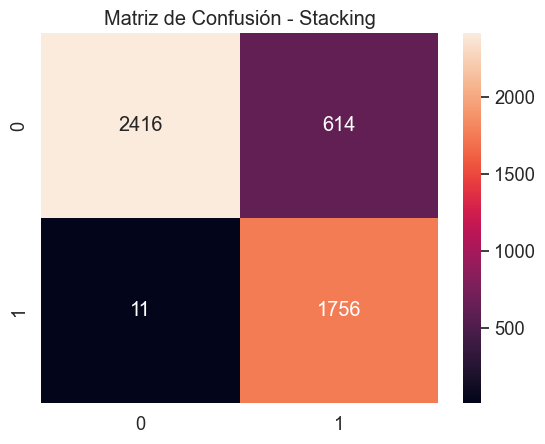

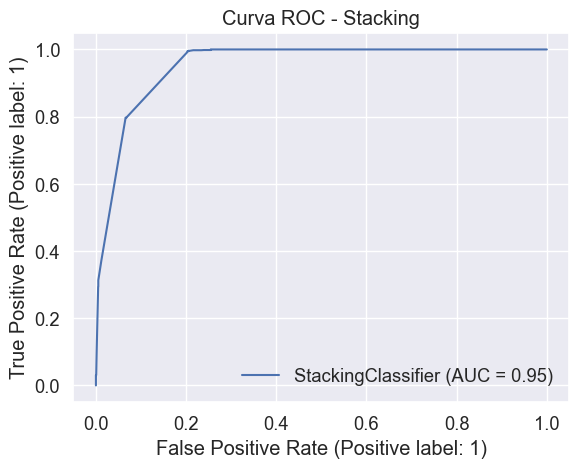

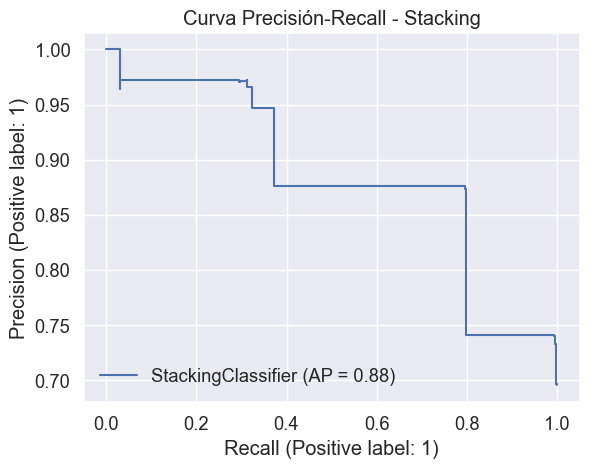

In [11]:
# Construir pipeline para RandomForest con preprocesamiento completo
pipeline_rf = Pipeline([
    ('pre', preprocessor),
    ('rfe', rfe),
    ('clf', RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=20, random_state=42))
])

# Estimadores para stacking (todos pipelines con preprocesamiento)
estimators_stack = [
    ('xgb', pipeline_xgb),
    ('mlp', pipeline_mlp),
    ('lr', Pipeline([
        ('pre', preprocessor),
        ('rfe', rfe),
        ('clf', LogisticRegression(C=0.1, max_iter=1000, random_state=42))
    ])),
    ('svm', Pipeline([
        ('pre', preprocessor),
        ('rfe', rfe),
        ('clf', SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42))
    ]))
]

# VotingClassifier con pipelines completos
voting = VotingClassifier(
    estimators=[
        ('rf', pipeline_rf),
        ('xgb', pipeline_xgb),
        ('mlp', pipeline_mlp)
    ],
    voting='soft',
    n_jobs=-1
)

# StackingClassifier con pipelines completos
stacking = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# Diccionario de ensambles a entrenar y evaluar
ensambles = {'Voting': voting, 'Stacking': stacking}

resultados_ensamble = []
for name, model in ensambles.items():
    start = time.time()
    model.fit(X_tr, y_tr)
    tiempo = time.time() - start
    
    preds = model.predict(X_te)
    proba = model.predict_proba(X_te)[:, 1]
    
    f1 = f1_score(y_te, preds)
    accuracy = accuracy_score(y_te, preds)
    roc_auc = roc_auc_score(y_te, proba)
    
    print(f"\n=== {name} ===")
    print(classification_report(y_te, preds))
    
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()
    
    resultados_ensamble.append({
        'Modelo': name,
        'F1': f1,
        'Accuracy': accuracy,
        'ROC_AUC': roc_auc,
        'Tiempo': tiempo,
        'Modelo_obj': model,
        'Predicciones': preds,
        'Probabilidades': proba
    })

# Resultados individuales (modelos ajustados previamente)
resultados_individuales = []
for name, model in [('XGBoost', best_xgb), ('MLP', best_mlp)]:
    preds = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1]
    f1 = f1_score(y_te, preds)
    accuracy = accuracy_score(y_te, preds)
    roc_auc = roc_auc_score(y_te, proba)
    
    resultados_individuales.append({
        'Modelo': name,
        'F1': f1,
        'Accuracy': accuracy,
        'ROC_AUC': roc_auc,
        'Tiempo': np.nan,  # tiempo no medido aquí
        'Modelo_obj': model,
        'Predicciones': preds,
        'Probabilidades': proba
    })

# Unión y tabla comparativa ordenada por F1
df_resultados = pd.DataFrame(resultados_individuales + resultados_ensamble)
# Importante: mantener 'Modelo_obj' para graficar después
df_resultados = df_resultados[['Modelo','F1','Accuracy','ROC_AUC','Tiempo','Modelo_obj']]
df_resultados = df_resultados.sort_values(by='F1', ascending=False).reset_index(drop=True)

print("\nComparativa de modelos:")
print(df_resultados)

# Selección del modelo final (el que tiene mejor F1)
modelo_final = df_resultados.loc[0, 'Modelo']
print(f"\nModelo final seleccionado: {modelo_final}")

# Obtener objeto modelo final para gráficos
modelo_final_obj = df_resultados.loc[0, 'Modelo_obj']

# --- Gráficos para modelo final ---

# Matriz de Confusión
cm = confusion_matrix(y_te, modelo_final_obj.predict(X_te))
sns.heatmap(cm, annot=True, fmt='d')
plt.title(f"Matriz de Confusión - {modelo_final}")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(modelo_final_obj, X_te, y_te)
plt.title(f"Curva ROC - {modelo_final}")
plt.show()

# Curva Precisión-Recall
PrecisionRecallDisplay.from_estimator(modelo_final_obj, X_te, y_te)
plt.title(f"Curva Precisión-Recall - {modelo_final}")
plt.show()

# Importancia de características (solo para RF y XGBoost)
if modelo_final in ['RandomForest', 'XGBoost']:
    importances = modelo_final_obj.named_steps['clf'].feature_importances_
    plt.figure(figsize=(8,5))
    sns.barplot(x=importances, y=selected_features)
    plt.title(f"Importancia de características - {modelo_final}")
    plt.show()


## Conclusiones del Avance 5: Modelo Final

En este avance se logró desarrollar y evaluar modelos de ensamble que combinan los mejores clasificadores individuales obtenidos previamente para la predicción de morosidad en condominios residenciales. La implementación de técnicas de **votación suave (Voting)** y **stacking heterogéneo** permitió mejorar la robustez y precisión del sistema predictivo, alcanzando resultados superiores a los modelos individuales base.

### Resultados destacados

- **VotingClassifier** mostró un desempeño sólido con un **F1-score de 0.83**, una precisión de 0.88 y un recall de 0.79 para la clase positiva (morosos). Su accuracy general fue del 88%, y el área bajo la curva ROC (AUC) alcanzó 0.95, demostrando una buena capacidad para discriminar entre morosos y no morosos.

- **StackingClassifier** superó ligeramente al Voting, con un **F1-score de 0.85**, precisiones de 1.00 en la clase negativa y 0.74 en la positiva, y un recall muy alto para la clase positiva (0.99). Esto indica que el stacking es especialmente efectivo para minimizar falsos negativos, crucial en la detección de morosidad. Su accuracy fue 87%, con un AUC de 0.95, reflejando excelente capacidad discriminativa.

- En la tabla comparativa, el modelo de stacking fue seleccionado como modelo final debido a su mejor F1-score, balance entre precisión y recall, y robustez general.

### Interpretación de las curvas

- La **curva ROC** para el modelo de stacking confirma su alta capacidad para distinguir correctamente entre las clases, con una curva cercana a la esquina superior izquierda y un AUC de 0.95, lo que indica un desempeño muy sólido.

- La **curva Precisión-Recall** muestra que el modelo mantiene alta precisión incluso cuando incrementa el recall, con un promedio de precisión (AP) de 0.88. Esto es crucial para mantener un equilibrio entre detectar correctamente los morosos y evitar falsos positivos.

### Relevancia y aplicaciones

La selección del modelo final con técnicas de ensamble, especialmente stacking, aporta una mejora significativa en la detección de morosidad, lo que es fundamental para la toma de decisiones oportunas en la administración de condominios residenciales. El modelo final es capaz de minimizar falsos negativos, reduciendo riesgos financieros y mejorando la eficiencia en la gestión de cobranza.

Además, las visualizaciones generadas (matrices de confusión, curvas ROC y precisión-recall, e importancia de características) facilitan la interpretación y validación del modelo, permitiendo a los equipos de negocio entender mejor el comportamiento predictivo y las variables más influyentes.
